In [0]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor, split
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.functions import sum as Fsum
import datetime

### Load Data

The data contains info below: 

-artist : artist being listened\
-auth : user log in/out\
-firstName : name of customer\
-gender : gender of customer\
-itemInSession : item in session\
-lastName : surname of customer\
-length : length of time for specific log\
-level : free or paid subsrciption\ 
-location : city and state in which customer use service\
-method : get and put methods\
-page : which page event which customers perform\
-registration : user registration date\
-sessionId : session id of user\
-song : song which customer listen\
-status : web status\
-ts : time stamp of event log\
-userAgent : browser and machine details of customer\
-userId : customer/ user ID\

In [0]:
data = spark.read.format("json").load("dbfs:/FileStore/shared_uploads/e0926898@u.nus.edu/mini_sparkify_event_data.json")

In [0]:
df = data.where((data.userId != "") | (data.sessionId != ""))

##### Define Churn and Downgraded Users 

The data is extracted from "page" column

In [0]:
churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))


##### Create City and State Column

The data is extracted from location" column

In [0]:
split_col = split(df['location'], ',')
df = df.withColumn('City', split_col.getItem(0))
df = df.withColumn('State', split_col.getItem(1))

### Data Analysis/ Visualisation

##### 1. Explore in SQL

In [0]:
df.createOrReplaceTempView("Sparkify_df")

In [0]:
%sql

SELECT gender,COUNT(DISTINCT userId) AS user_counts
FROM Sparkify_df
GROUP BY gender
ORDER BY user_counts DESC;


gender,user_counts
M,121
F,104


In [0]:
%sql

SELECT page,COUNT(userId) AS user_counts
FROM Sparkify_df
GROUP BY page
ORDER BY user_counts DESC;

page,user_counts
NextSong,228108
Thumbs Up,12551
Home,10082
Add to Playlist,6526
Add Friend,4277
Roll Advert,3933
Logout,3226
Thumbs Down,2546
Downgrade,2055
Settings,1514


##### 2. Visualisation using Pandas/ Seaborn

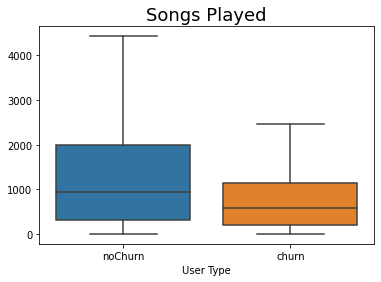

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
song=udf(lambda x : int(x=='NextSong'), IntegerType())
df = df.withColumn("churn_phase", Fsum("cancelled").over(windowval))\
    .withColumn("downgrade_phase", Fsum("downgraded").over(windowval))

song_play_pd = df.filter(col('churn_phase')==1).withColumn('songPlayed', song(col('page')))\
.groupBy('userId').count().toPandas()

song_play_0_pd = df.filter(col('churn_phase')==0).withColumn('songPlayed', song(col('page')))\
.groupBy('userId').count().toPandas()

song_play_0_pd.columns=['userId', 'noChurn']
song_play_pd.columns=['userId', 'churn']

ax = sns.boxplot(data=pd.concat([song_play_0_pd['noChurn'], song_play_pd['churn']], axis=1), showfliers=False)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax.set(xlabel='User Type', title='Songs Played');

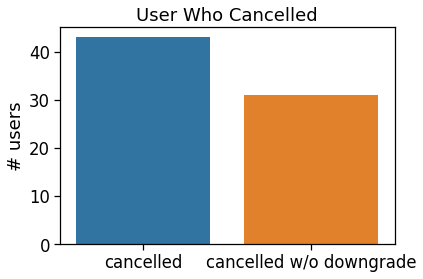

In [0]:
#number of users to cancel w/o downgrade
cancel = df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==0)&(col("cancelled")==1))\
    .count()
downgrade_paid = df.filter((col('cancelled')==1) & (col('downgraded')==0) & (col('level')=='paid'))\
      .select('userId').dropDuplicates().count()

ax = sns.barplot(data=pd.DataFrame({'cancelled':[cancel], 'cancelled w/o downgrade':[downgrade_paid]}))
ax.set(title='User Who Cancelled', ylabel='# users')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5});

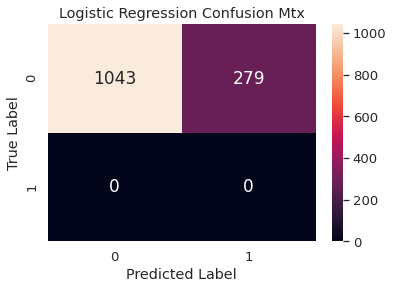

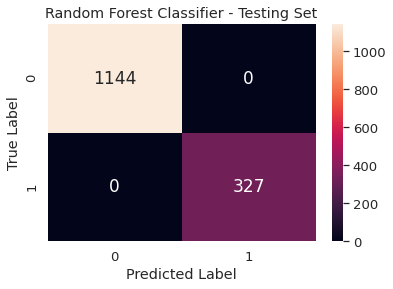

In [0]:
def conf_mtx(mtx, title=None):
    '''
    [[TN, FN], [FP, TP]]
    '''
    
    if(title==None):
        title='Confusion Mtx'
        
    sns.set(font_scale=1.2)#for label size
    ax = sns.heatmap(mtx, annot=True,annot_kws={"size": 17}, fmt='g')
    ax.set(xlabel='Predicted Label', ylabel='True Label', title=title)
    plt.show()
    
conf_mtx_test=[[1144,0],[0,327]]

conf_mtx_1 = [[1043, 279], [0, 0]]

conf_mtx(conf_mtx_1, 'Logistic Regression Confusion Mtx')

conf_mtx(conf_mtx_test, 'Random Forest Classifier - Testing Set')

### Data Cleaning / Preprocessing

Overview:

- create user level data based on user actions (pages visited, songs listened to, etc).
- set up data for machine learning algorithms (ML algos use specific data types in Spark)

In [0]:
def feature_engineering(df):
    
    #Clean data of any rows where user id or session id are null, as this would interfere with feature engineering
    users = df.where((df.userId != "") | (df.sessionId != ""))\
        .select('userId').dropDuplicates()
    
    #define custom functions
    churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
    visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())
    visited_cancel = udf(lambda x: int(x=='Cancel'), IntegerType())
    song = udf(lambda x: int(x=='NextSong'), IntegerType())
    days = lambda i: i * 86400 
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    skipped = udf(lambda x: int(x!=0), IntegerType())
    free = udf(lambda x: int(x=='free'), IntegerType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())
    home_visit=udf(lambda x : int(x=='Home'), IntegerType())
    
    #define windows
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    session = Window.partitionBy("userId", "sessionId").orderBy(desc("ts"))
    daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts'))\
        .rangeBetween(Window.unboundedPreceding, 0)

    avgThumbsUp = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean().withColumnRenamed('avg(count(page))', 'avgThumbsUp')
    
    avgThumbsDown = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'avgThumbsDown')
    
    numFriends = df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends')
    
    skipping = df.select('userId', 'page', 'ts', 'length', 'sessionId', 'itemInSession')\
        .where((df.page != 'Thumbs Up') & (df.page != 'Thumbs Down'))\
        .withColumn('song', song('page')).orderBy('userId', 'sessionId', 'itemInSession')\
        .withColumn('nextActSong', lag(col('song')).over(session))\
        .withColumn('tsDiff', (lag('ts').over(session)-col('ts'))/1000)\
        .withColumn('timeSkipped', (floor('length')-col('tsDiff')))\
        .withColumn('roundedLength', floor('length'))\
        .where((col('song')==1) & ((col('nextActSong')!=0)&(col('timeSkipped')>=0)))\
        .withColumn('skipped', skipped('timeSkipped'))\
        .select('userId', 'timeSkipped', 'skipped', 'length', 'ts', 'tsDiff')\
        .groupBy('userId').agg({'skipped':'avg', 'timeSkipped':'avg'})\
        .withColumnRenamed('avg(skipped)', 'skipRate')\
        .withColumnRenamed('avg(timeSkipped)', 'avgTimeSkipped')
    
#avg daily visits to help site
    dailyHelpVisit = df.filter(df.page=='Help')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
         .withColumnRenamed('avg(count(page))', 'dailyHelpVisits')

    dailyErrors = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'dailyErrors')
    
    #whether a user has downgraded
    churn = df.withColumn("downgraded", downgrade_churn("page"))\
        .withColumn("cancelled", churn("page"))\
        .withColumn('visited_cancel', visited_cancel('page'))\
        .withColumn('visited_downgrade', visited_downgrade('page'))\
        .select(['userId', 'downgraded', 'cancelled', 'visited_cancel', 'visited_downgrade'])\
        .groupBy('userId').sum()\
        .withColumnRenamed('sum(downgraded)', 'downgraded')\
        .withColumnRenamed('sum(cancelled)', 'cancelled')\
        .withColumnRenamed('sum(visited_cancel)', 'visited_cancel')\
        .withColumnRenamed('sum(visited_downgrade)', 'visited_downgrade')

    user_level = df.select('userId', 'level')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free', free('level'))\
        .withColumn('paid', paid('level')).drop('level')

    cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', home_visit(col('page'))) \
        .withColumn('songPeriod', Fsum('homevisit').over(windowval))\
    
    avgSongsTillHome = cusum.filter((cusum.page=='NextSong'))\
        .groupBy('userId', 'songPeriod')\
        .agg({'songPeriod':'count'}).drop('songPeriod')\
        .groupby('userId').mean()\
        .withColumnRenamed('avg(count(songPeriod))', 'avgSongsTillHome')
    
    df = users.join(churn, on='userId')\
        .join(dailyHelpVisit, on='userId')\
        .join(dailyErrors, on='userId')\
        .join(user_level, on='userId')\
        .join(avgThumbsUp, on='userId')\
        .join(avgThumbsDown, on='userId')\
        .join(numFriends, on='userId')\
        .join(avgSongsTillHome, on='userId')\
        .join(skipping, on='userId')
    
    return df

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType

def feature_scaling(df):
    feature_cols = df.drop('userId', 'cancelled').columns
    assembler = VectorAssembler(inputCols=feature_cols,\
                                outputCol='feature_vec')
    
    #pyspark.ml expects target column to be names: 'labelCol', w/ type: Double
    df = df.withColumn("label", df["cancelled"].cast(DoubleType()))
    
    #pyspark default name for features vector column: 'featuresCol'
    minmaxscaler = MinMaxScaler(inputCol="feature_vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df

In [0]:
#define function to check the performance of the model

def evaluation(pred, model_name):
    '''
    Perform custom evaluation of predictions
    
    1.inspect with PySpark.ML evaluator (will use for pipeline)
    2. use RDD-API; PySpark.MLLib to get metrics based on predictions 
    3. display confusion matrix
    
    Inspiration from: https://chih-ling-hsu.github.io/2018/09/17/spark-mllib
    https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html
    https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    
    Inputs
        preds(PySpark.ml.DataFrame) - predictions from model
    '''
    #want to evaluate binary class, auc_pr is best for imbalanced classes
    tn_sum = pred.filter((pred.label == 0)&(pred.prediction==0)).count() #true negative
    fn_sum = pred.filter((pred.label == 1)&(pred.prediction==0)).count() #false negative
    fp_sum = pred.filter((pred.label == 0)&(pred.prediction==1)).count() #false positive
    tp_sum = pred.filter((pred.label == 1)&(pred.prediction==1)).count() #true positive

    print("{} \n | tn:{}| fn:{}| fp:{}| tp:{}".format(model_name, tn_sum, fn_sum, fp_sum, tp_sum))

### Modelling

In [0]:
data = spark.read.format("json").load("dbfs:/FileStore/shared_uploads/e0926898@u.nus.edu/mini_sparkify_event_data.json")

df = feature_engineering(data)
df_scaled = feature_scaling(df)
df_scaled.collect()[0]

Out[24]: Row(userId='51', downgraded=0, cancelled=1, visited_cancel=1, visited_downgrade=23, dailyHelpVisits=1.7142857142857142, dailyErrors=1.0, free=0, paid=1, avgThumbsUp=8.333333333333334, avgThumbsDown=2.1, numFriends=28, avgSongsTillHome=29.319444444444443, avgTimeSkipped=0.0, skipRate=0.0, label=1.0, feature_vec=DenseVector([0.0, 1.0, 23.0, 1.7143, 1.0, 0.0, 1.0, 8.3333, 2.1, 28.0, 29.3194, 0.0, 0.0]), features=DenseVector([0.0, 1.0, 0.3151, 0.2381, 0.0, 0.0, 1.0, 0.8722, 0.3667, 0.1901, 0.7032, 0.5, 0.5]))

In [0]:
#split data for training
train, rest = df_scaled.randomSplit([0.85, 0.15], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42)

#### 1. Logistic Regression Metrics:

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [0]:
# initialize classifier, set evaluater and build paramGrid
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = logReg.fit(train)
lr_preds = lrModel.transform(validation)

evaluation(lr_preds, 'Logistic Regression')

Logistic Regression 
 tn:5| fn:2| fp:0| tp:0

#### 2. Random Forest Metrics:

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=10)
rf_model = rf.fit(train)
rf_preds = rf_model.transform(validation)

evaluation(rf_preds, 'Random Forest')

Random Forest 
 tn:5| fn:0| fp:0| tp:2

#### 3. Gradient Boosted Trees Metrics:

In [0]:
from pyspark.ml.classification import GBTClassifier

gbtrees = GBTClassifier(maxIter=10, seed =42)
gbtree_model = gbtrees.fit(train)
gbtree_preds = gbtree_model.transform(validation)

evaluation(gbtree_preds, 'Gradient Boosted Trees')

Gradient Boosted Trees 
 tn:5| fn:0| fp:0| tp:2

#### Comparison

In [0]:
#visual check for predictions
for x in [lr_preds, gbtree_preds, rf_preds]:
    x.select('features', 'rawPrediction', 'prediction', 'label').show(20)

+--------------------+--------------------+----------+-----+
 features| rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
[0.33333333333333...|[0.33684053000255...| 0.0| 1.0|
[0.0,0.0,0.287671...|[1.88795217084495...| 0.0| 0.0|
[0.66666666666666...|[1.88795217084495...| 0.0| 0.0|
[0.0,0.0,0.027397...|[1.88795217084495...| 0.0| 0.0|
[0.0,0.0,0.287671...|[1.88795217084495...| 0.0| 0.0|
[0.0,1.0,0.013698...|[0.33684053000255...| 0.0| 1.0|
[0.33333333333333...|[1.88795217084495...| 0.0| 0.0|
+--------------------+--------------------+----------+-----+

+--------------------+--------------------+----------+-----+
 features| rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
[0.33333333333333...|[-1.3259026792203...| 1.0| 1.0|
[0.0,0.0,0.287671...|[1.32590267922033...| 0.0| 0.0|
[0.66666666666666...|[1.32590267922033...| 0.0| 0.0|
[0.0,0.0,0.027397...|[1.32590267922033...| 0.0| 0.0|
[0.0,0.0,0.287671...|[1.32590267922033...| 0.0| 0.0|
[0.0,1.0,0.013698...|[-1.3259026792203...| 1.0| 1.0|
[0.33333333333333...|[1.32590267922033...| 0.0| 0.0|
+--------------------+--------------------+----------+-----+

+--------------------+-------------+----------+-----+
 features|rawPrediction|prediction|label|
+--------------------+-------------+----------+-----+
[0.33333333333333...| [1.0,9.0]| 1.0| 1.0|
[0.0,0.0,0.287671...| [10.0,0.0]| 0.0| 0.0|
[0.66666666666666...| [10.0,0.0]| 0.0| 0.0|
[0.0,0.0,0.027397...| [9.0,1.0]| 0.0| 0.0|
[0.0,0.0,0.287671...| [10.0,0.0]| 0.0| 0.0|
[0.0,1.0,0.013698...| [1.0,9.0]| 1.0| 1.0|
[0.33333333333333...| [10.0,0.0]| 0.0| 0.0|
+--------------------+-------------+----------+-----+